#### Sobre o problema

- O Sudoku Clássico consiste em uma grade 9x9 `(com um pequeno quadrado (célula) para cada número e uma outra divisão em grades de 3x3, representando as regiões (quadrantes))`, parcialmente preenchida, onde devem ser encontrados os locais corretos para preencher com números de 1 a 9, de modo com que nenhum número se repita na mesma linha, coluna ou quadrante.

<center>
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/f/ff/Sudoku-by-L2G-20050714.svg/250px-Sudoku-by-L2G-20050714.svg.png" alt="Sudoku Clássico">

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/3/31/Sudoku-by-L2G-20050714_solution.svg/250px-Sudoku-by-L2G-20050714_solution.svg.png" alt="Sudoku Clássico Resolvido">
</center>

- Em algumas instâncias do sudoku parcialmente preenchido, é possível encontrar mais de uma solução possível, mas como o sudoku é considerado um problema de lógica pura, é esperado que exista somente uma solução possível. 

#### Variantes do sudoku

- O sudoku de 9x9 é o mais conhecido, porém, existem diversas variações do problema com outros tamanhos e abordagens. Abaixo segue uma representação de um sudoku 9x9, mas com seus quadrantes definidos aleatoriamente.

<center>
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/5/5f/Nonomino_Sudoku.svg/220px-Nonomino_Sudoku.svg.png" alt="Sudoku Variante">
</center>

- Modelagem do sudoku de tamanho 10x10

<center>
<img src="10x10.png" alt="Sudoku 10x10" width="250" height="250">
</center>

- Modelagem do sudoku de tamanho 15x15

<center>
<img src="https://static.wikia.nocookie.net/logic-puzzles/images/6/63/15x15_Sudoku.png/revision/latest?cb=20140518185305" alt="Sudoku 15x15">
</center>

- Alguns tamanhos de sudoku, geralmente os sudokus de tamanhos primos, como 11x11, 13x13, 17x17... São considerados `pseudosudokus` por não poderem ter as células distribuidas de forma igualitária em cada quadrante. 

<center>
<img src="11x11.png" alt="Sudoku 10x10" width="300" height="300">
</center>

#### Abordagem planejada

- Planejamos uma abordagem `não-supervisionada` de máquina, onde vamos modelar a `grade` do sudoku para um formato de grafo. O tamanho da grade do sudoku não vai ser fixo, estamos planejando trabalhar com um `n-sudoku`. Planejamos utilizar algum algoritmo de coloração de vértices `(em aberto ainda)` para aplicar as restrições do sudoku e ainda considerar cada cluster como sendo uma cor também.

#### Problemas esperados

- Para uma abordagem com n-sudokus, é esperado que para alguns tamanhos de grade, como 10x10 ou 11x11, a forma como os quadrantes vão ser construidos pode acabar se tornando um contra-tempo na hora de visualizar melhor o agrupamento dos clusters. Por isso, optamos em trabalhar com grades que sejam múltiplas de três, de forma a padronizar as saídas e melhorar a visualização. 

- Segundo problema esperado, estão ocorrendo colisões porque ainda não conseguimos aplicar restrições de cores aos vértices, mas conseguimos atribuir um cluster para cada quadrante. Estamos pensando em uma abordagem que consiga afastar os dados o máximo possível uns dos outros. `(em aberto ainda)`

#### Restrições esperadas

1. Não pode ocorrer repetição de cor na linha;

2. Não pode ocorrer repetição de cor na coluna;

3. Não pode ocorrer repetição de cor no quadrante;

4. Cada cor deve aparecer exatamente N-vezes

5. Não conseguimos específicar a ausência da cor `(maior problema até agora)`

6. Estavamos tentando resolver já especificando algumas cores, mas decidimos dar um passo para trás e tentar resolver primeiro com a ausência de cores em todo o sudoku.

<center>
<img src="ligações.png" alt="Sudoku ligações">
</center>

#### Trabalhos relacionados

    Abordagem com Redes Neurais e Aprendizado Profundo"

- Redes Neurais Convolucionais (CNNs) são um tipo de arquitetura de rede neural projetada especialmente para o processamento de dados que têm uma estrutura de grade, como imagens.

- As CNNs foram inspiradas na arquitetura do córtex visual do cérebro humano, que é altamente eficaz na detecção de características visuais em camadas hierárquicas. As principais características das CNNs incluem:

- Construindo um modelo de aprendizado profundo para resolver o Sudoku: um estudo de caso com CNNs, Qichun Yu

- As camadas convolucionais são o bloco fundamental das CNNs. Elas consistem em neurônios que aplicam operações de convolução nas entradas. A convolução envolve a aplicação de filtros ou kernels deslizantes sobre a entrada para extrair características locais. Esses filtros aprendem a detectar padrões, como bordas, texturas e formas.

- Divisão de dados com uma proporção de 80/20. Os primeiros 800.000 dados (80%) como conjunto de treinamento e os últimos 200.000 dados (20%) como conjunto de teste.

- Ele Utilizou 11 modelos de redes neurais convolucionais, os 10 primeiros tinham taxa de acerto inferiores a 75%. No décimo primeiro, a taxa de precisão subiu para 95% no treinamento e 98% na validação. O modelo 11 inclui 9 camadas de convolução com 512 kernels. O estudo descobriu que um aumento no número de camadas e no número de neurônios por camada pode ajudar a melhorar a precisão do modelo de rede neural.

- Aplicando em um sudoku real, o modelo teve uma precisão de acertar 196 mil casos de 200 mil.

- Por fim, a abordagem com redes neurais e aprendizado profundo retornou um resultado ótimo e consegue ser capaz de resolver problemas de um sudoku clássico (9x9)

- Site onde foram conseguidos os 1 milhão de sudokus: https://www.kaggle.com/datasets/bryanpark/sudoku

    Abordagem com Algoritmo Genético

- Um algoritmo genético NÃO é um algoritmo de aprendizagem.

- Algoritmos evolucionários, um algoritmo genético segue o mesmo padrão de comportamento básico:

    1. Um conjunto de soluções preliminares é gerada aleatoriamente; este conjunto é chamado de população; geralmente o número de soluções é arbitrado em 100; como haverá várias versões desta população, cada uma das versões é chamada de geração; a primeiríssima geração é chamada de geração inicial; cada solução dessas é chamada de indivíduo;

    2. As soluções presentes na geração atual são avaliadas por uma função capaz de atestar a qualidade de um dado indivíduo; a qualidade varia, normalmente, entre 0 e 1, onde 1 indica a solução ótima e os outros valores uma medida de proximidade da solução ótima; esta função é chamada de função de fitness;

    3. Cada um dos indivíduos de toda a população é avaliado sob a função de fitness;

    4. Com a qualidade de cada um dos indivíduos calculada, avalia-se se já existe algum indivíduo de qualidade suficiente para servir de solução; em caso positivo a busca termina; pode-se também decidir terminar a execução se a quantidade de gerações até o momento atingiu um limiar de parada;

    5. No caso de nenhum individuo representar uma solução aceitável, alguma eurística é adotada para decidir quais dos indivíduos da geração atual devem passar para a geração seguinte e quais desaparecerão; assim, depois de selecionados os indivíduos para compor a geração seguinte, esta pode ter que ser complementada com novos indivíduos, novamente gerados pseudo-aleatoriamente ou por algum outra heurística;

    6. Com a nova geração pronta, retorna-se ao passo 2.

- Como todo algoritmo evolucionário, não se espera chegar à solução ótima, mas se espera chegar a uma solução de qualidade 95% ao menos com esforço menor que 10% da busca exaustiva.

- Um artigo sobre algoritmo genético para resolução do sudoku foi publicado na Conferência Internacional sobre Técnicas Elétricas, Eletrônicas e de Otimização 2016 (ICEEOT). Título do artigo: Uma nova abordagem de algoritmo genético de vários estágios para resolver quebra-cabeças de Sudoku

- Nesse artigo, os algoritmos foram aplicados a sudokus de níves: simples, fácil, médio e difícil. A taxa de sucesso de saída não foi exatamente tão boa, como mostrado na imagem a seguir:

<center>
<img src="ciclos.png" alt="ciclos resultados" width="250" height="250">
</center>

### Bibliotecas

In [111]:
# Para criação e manipulação de DataFrame
import pandas as pd

# Para trabalhar com arrays e matrizes multidimensionais e outras funções matemáticas
import numpy as np

# Criação e manipulação de Grafos
import networkx as nx

# Para visualização dos dados
import matplotlib.pyplot as plt


# Para Padronização dos dados
from sklearn.preprocessing import StandardScaler 

# Para o k-means
from sklearn.cluster import KMeans

# Para o Agrupamento Hierarquico
from sklearn.cluster import AgglomerativeClustering

# Para o Agrupamento com base na densidade
from sklearn.cluster import DBSCAN

### Criação do grafo

#### Biblioteca networkx

1. Criação de Grafos:
- `nx.Graph()`: Cria um grafo não direcionado.
- `nx.DiGraph()`: Cria um grafo direcionado.

2. Adição e Remoção de Vértice e Arestas:

- `G.add_node(node)`: Adiciona um nó ao grafo.
- `G.add_edge(node1, node2)`: Adiciona uma aresta entre dois vértice.
- `G.remove_node(node)`: Remove um vértice do grafo.
- `G.remove_edge(node1, node2)`: Remove a aresta entre dois vértice.

4. Visualização de Grafos:

- `nx.draw(G)`: Desenha o grafo na tela.
- `nx.draw_shell(G)`: Desenha o grafo em um layout "shell".
- `nx.draw_circular(G)`: Desenha o grafo em um layout circular.

4. Acesso a Atributos de Nós e Arestas:

- `G.nodes()`: Retorna uma lista de todos os nós.
- `G.edges()`: Retorna uma lista de todas as arestas.
- `G[v1]`: Retorna um dicionário de vizinhos de um nó.

5. Informações sobre o Grafo:

- `nx.is_connected(G)`: Verifica se o grafo é conexo.

6. Algoritmos de Grafos:

- `nx.shortest_path(G, vertice_inicial, vertice_final)`: Encontra o caminho mais curto entre dois vértice.
- `nx.minimum_spanning_tree(G)`: Encontra a árvore de expansão mínima.
- `nx.degree_centrality(G)`: Calcula a centralidade dos vértice.

7. Análise de Redes:

- `nx.clustering(G)`: Calcula o coeficiente de aglomeração de cada vértice. Para grafos não ponderados, o agrupamento de um vértice é a fração de triângulos possíveis que existem.
- `nx.average_shortest_path_length(G)`: Calcula o caminho médio mais curto em um grafo.

#### Modelando o Sudoku NxN em um grafo

In [112]:
def create_sudoku_grafo(N):
    if N % 3 == 0: # It will only accept sudoku sizes that are multiples of 3 to standardize the quadrants
        G = nx.Graph()

        info_vertices_sudoku = []

        for line in range(1, N + 1): # For the lines
            for column in range(1, N + 1): # For de columns
                quadrant = (line - 1) // int(np.sqrt(N)) * int(np.sqrt(N)) + (column - 1) // int(np.sqrt(N)) + 1 # Formula for calculating quadrants in Sudoku
                info_vertices_sudoku.append([line, column, quadrant])
        
        for vertice in info_vertices_sudoku:
            vertice_grafo = int(str(vertice[0]) + str(vertice[1]) + str(vertice[2]))
            G.add_node(vertice_grafo)

        for vertice in info_vertices_sudoku:
            for vertice_adj in info_vertices_sudoku:
                if vertice != vertice_adj: # Não pode ter laço
                    # Se tiverem a mesma linha, coluna ou quadrante, significa que existe uma aresta.
                    if vertice[0] == vertice_adj[0] or vertice[1] == vertice_adj[1] or vertice[2] == vertice_adj[2]:
                        G.add_edge(int(str(vertice[0]) + str(vertice[1]) + str(vertice[2])), int(str(vertice_adj[0]) + str(vertice_adj[1]) + str(vertice_adj[2])))

        return G
    else:
        print("The size of N is not a multiple of 3.")

Essa função cria um DataFame que representa um tabuleiro de Sudoku NxN, onde cada registro contém informações sobe a linha, coluna e quadrante do vértice.

- Cada vértice é representado por um número de `três` dígitos. Por exemplo, `123` indica que o vértice pertence à `linha 1`, `coluna 2` e `quadrante 3`.

- `quadrant`: Calcula o número do quadrante ao qual o vértice pertence. Esta linha utiliza uma fórmula que é comummente usada para determinar o quadrante de uma célula em um tabuleiro de Sudoku.

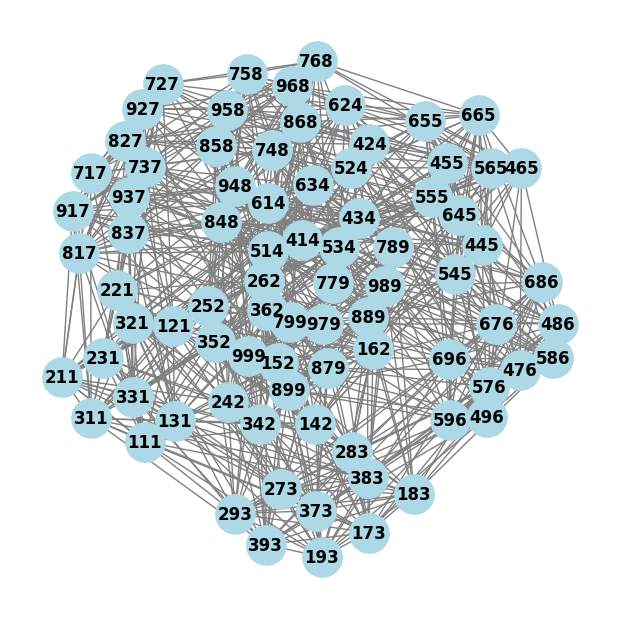

In [113]:
grafo = create_sudoku_grafo(9)
type(grafo)

pos = nx.spring_layout(grafo)

plt.figure(figsize=(6, 6))
nx.draw(grafo, pos, with_labels=True, node_color='lightblue', node_size=800, font_size=12, edge_color='gray', font_weight='bold')

plt.show()

### Criação do dataframe

#### 1º Abordagem: criar um dataframe a partir do Sudoku em si

In [114]:
def create_sudoku_dataframe(N):
    if N % 3 == 0: # It will only accept sudoku sizes that are multiples of 3 to standardize the quadrants

        data = []

        for line in range(1, N + 1): # For the lines
            for column in range(1, N + 1): # For de columns
                quadrant = (line - 1) // int(np.sqrt(N)) * int(np.sqrt(N)) + (column - 1) // int(np.sqrt(N)) + 1
                    # Formula for calculating quadrants in Sudoku
                data.append([line, column, quadrant])

        columns = ['line_v', 'column_v', 'quadrant_v']

        data_frame = pd.DataFrame(data, columns = columns)

        return data_frame
    else:
        print("The size of N is not a multiple of 3.")


- `pd.DataFrame(data, columns = columns)`: Recebe uma matriz onde cada linha possui três valores, juntamente com as colunas correspondentes especificadas em `columns`.

In [115]:
sudoku_df = create_sudoku_dataframe(9)

Estamos Trabalhando com sudo múltiplo de 3 nesse estágio inicial da pesquisa.

In [116]:
sudoku_df.shape

(81, 3)

Note que foi criado um Sudoku padrão 81x81, com 9 quadrantes.

In [117]:
sudoku_df.head(20)

,line_v,column_v,quadrant_v
0,1,1,1
1,1,2,1
2,1,3,1
3,1,4,2
4,1,5,2
5,1,6,2
6,1,7,3
7,1,8,3
8,1,9,3
9,2,1,1


#### Escalonando os valores

In [118]:
scaler = StandardScaler() 

scaler_sudoku_df = scaler.fit_transform(sudoku_df)

`StandardScaler()`: utilizado na fase de pré-processamento para a padronização de um DataFrame. Normalmente a fómula é: `z = (x - mean) / std`, onde z é o novo valor padronizado, x é o valor original, mean é a média e std é o desvio padrão. 

In [119]:
scaler_sudoku_df

array([[-1.54919334, -1.54919334, -1.54919334],
       [-1.54919334, -1.161895  , -1.54919334],
       [-1.54919334, -0.77459667, -1.54919334],
       [-1.54919334, -0.38729833, -1.161895  ],
       [-1.54919334,  0.        , -1.161895  ],
       [-1.54919334,  0.38729833, -1.161895  ],
       [-1.54919334,  0.77459667, -0.77459667],
       [-1.54919334,  1.161895  , -0.77459667],
       [-1.54919334,  1.54919334, -0.77459667],
       [-1.161895  , -1.54919334, -1.54919334],
       [-1.161895  , -1.161895  , -1.54919334],
       [-1.161895  , -0.77459667, -1.54919334],
       [-1.161895  , -0.38729833, -1.161895  ],
       [-1.161895  ,  0.        , -1.161895  ],
       [-1.161895  ,  0.38729833, -1.161895  ],
       [-1.161895  ,  0.77459667, -0.77459667],
       [-1.161895  ,  1.161895  , -0.77459667],
       [-1.161895  ,  1.54919334, -0.77459667],
       [-0.77459667, -1.54919334, -1.54919334],
       [-0.77459667, -1.161895  , -1.54919334],
       [-0.77459667, -0.77459667, -1.549

##### Aplicando K-Means

In [120]:
kmeans = KMeans(n_clusters=9, init='k-means++', random_state=0).fit(scaler_sudoku_df)

- `KMeans()`: Importamos a classe para usar o KMeans. Ao atribuir a uma variável, estamos instânciando.
- `fit(scaler_sudoku_df)`: Treinamos o modelo KMeans usando os dados padronizados no scaler_sudoku_df. Neste caso, o algoritmo tenta encontrar 9 clusters que melhor representem a estrutura dos dados. Os rótulos de cluster resultantes são armazenados em `kmeans.labels_`.

##### Aplicando Agrupamento Hierárquico

In [121]:
hierarquico = AgglomerativeClustering(n_clusters=9).fit(scaler_sudoku_df)

- `AgglomerativeClustering()`: Importamos a classe para usar o Agrupamento Hierárquico de dados. Ao atribuir a uma variável, estamos instânciando.
- `fit(scaler_sudoku_df)`: Treinamos o modelo usando os dados padronizados no `scaler_sudoku_df`. Neste caso, o algoritmo tenta dividir os dados em 9 clusters e armazenar em `hieraquico`.

#### Aplicando DBSCAN

In [122]:
dbscan = DBSCAN(eps=0.5, min_samples=2).fit(scaler_sudoku_df)

- `AgglomerativeClustering()`: Importamos a classe para usar o DBSCAN, um algoritmo de agrupamento baseado em densidade. Não especificamos a quantidade de clusters previamente, pois ele define clusters com base na vizinhança de um registro. Utiliza um raio para percorrer os registros e agrupá-los. Se não houver mais registros dentro do alcance do raio, indica o fim do cluster. 

- `eps`: Indica o tamanho do raio.
- `min_samples`: Indica quantos registros deve ter dentro do raio para continuar.


#### Resultados

In [123]:
sudoku_df['hierarquico'] = hierarquico.fit_predict(scaler_sudoku_df)

sudoku_df['k_means'] = kmeans.fit_predict(scaler_sudoku_df)

sudoku_df['dbscan'] = dbscan.fit_predict(scaler_sudoku_df)

In [124]:
sudoku_df[sudoku_df["k_means"] == 0]

,line_v,column_v,quadrant_v,hierarquico,k_means,dbscan
33,4,7,6,4,0,5
34,4,8,6,4,0,5
35,4,9,6,4,0,5
42,5,7,6,4,0,5
43,5,8,6,4,0,5
44,5,9,6,4,0,5
51,6,7,6,4,0,5
52,6,8,6,4,0,5
53,6,9,6,4,0,5


Note que independente do algoritmo aplicado, o clusters sempre são os quadrantes.

#### 2º Abordagem: criar o DataFrame a partir das arestas do grafo

In [125]:
# Obtendo as arestas do grafo
list_aresta = [(vertice, aresta) for vertice, aresta in grafo.edges]

# Criando um DataFrame a partir das arestas do grafo
df_aresta = pd.DataFrame(list_aresta, columns=['vertice', 'vertice_adj'])

In [126]:
df_aresta.head()

,vertice,vertice_adj
0,111,121
1,111,131
2,111,142
3,111,152
4,111,162


#### 3º Abordagem: criar o DataFame a partir da Matriz de Adjacência do grafo complementar (Teste).

In [127]:
grafo_complementar = nx.complement(grafo)

# Obtendo a matriz de adjacência como um array numpy
matriz_adj = nx.to_numpy_array(grafo_complementar)

# Criando uma Base de dados a partir de um grafo (neste caso, um grafo complementar)
df_matriz = pd.DataFrame(matriz_adj, columns=grafo_complementar.nodes, index=grafo_complementar.nodes)

In [128]:
df_matriz

,111,121,131,142,152,162,173,183,193,211,...,899,917,927,937,948,958,968,979,989,999
111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
121,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
131,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
142,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
152,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
958,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
968,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
979,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
989,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [129]:
kmeans = KMeans(n_clusters=9, init='k-means++', random_state=0).fit(df_matriz.values)

# Adicionando o resultado o kmeans
df_matriz['kmeans'] = kmeans.labels_

In [130]:
df_matriz[df_matriz["kmeans"] == 8]

,111,121,131,142,152,162,173,183,193,211,...,917,927,937,948,958,968,979,989,999,kmeans
717,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,8
727,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,8
737,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,8
817,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,8
827,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,8
837,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,8
917,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8
927,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8
937,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8
